In [75]:
!uv pip install torch torchvision tqdm

Using Python 3.12.12 environment at: /usr
Audited 3 packages in 87ms


In [76]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import Dataset
from torch import Tensor
from abc import ABC, abstractmethod
from torch.nn.functional import relu
from torch.utils.data.dataloader import DataLoader
from tqdm.notebook import tqdm
import scipy.stats as st
from itertools import product

(-2.0, 2.0)

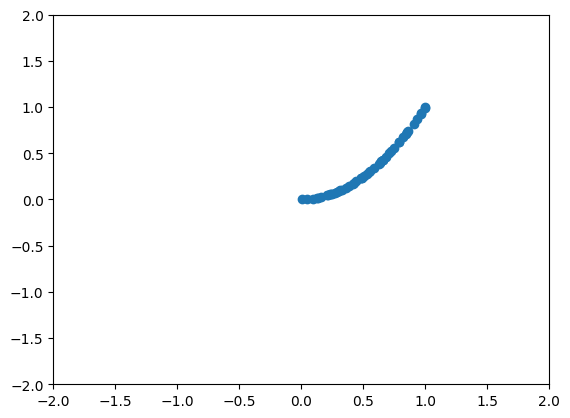

In [77]:
def manifold_func(x):
    return x**2

N_SAMPLES = 10000
x = torch.rand(size=(N_SAMPLES,))
y = manifold_func(x)
data = torch.stack([x,y],axis=1)

fig, ax = plt.subplots()
ax.scatter(data[:50,0],data[:50,1])
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)

In [78]:
from torch.utils.data import DataLoader, Dataset
class ManifoldDataset(Dataset):
    def __init__(self, data: torch.Tensor):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

dataset = ManifoldDataset(data)
batch_size = 128
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [79]:
class ItoSDE(ABC):
    def __init__(self, T_max: float):
        self.T_max = T_max
    
    @abstractmethod
    def cond_exp(self, X_0: Tensor, t: Tensor):
        pass
    
    @abstractmethod
    def cond_var(self, X_0: Tensor, t: Tensor):
        pass
    
    @abstractmethod
    def f_drift(self , X_t: Tensor, t: Tensor):
        pass

    @abstractmethod
    def g_random(self, X_t: Tensor, t: Tensor):
        pass

    def cond_std(self, X_0: Tensor, t: Tensor):
        """Conditional standard deviation. Square root of self.cond_var."""
        return torch.sqrt(self.cond_var(X_0, t))
    
    def sample_random_times(self, length: int):
        """Sample 'length' time points uniformly in interval [0,T]"""
        return torch.rand(size=(length,))*self.T_max

    @staticmethod
    def _mult_first_dim(t, X):
        """ 
        Helper function to multiply one-dimensional time vector with tensor of
        arbitrary shape.
        Inputs:
            X_0: shape (n,*,*,...,*)
            t: shape (n)
        Outputs:
            has same shape as X_0 - inputs X_0[i] multipled with t[i]
        """
        return t.view(-1,*[1]*(X.dim()-1))*X

    def run_forward(self, X_0: Tensor, t: Tensor, clip_factor: float = 0.01):
        """
        Function to evolve SDE forward in time from 0 to t<=self.T_max.
        Assume that conditional distribution is Gaussian
        Inputs:
            X_0: shape (n,*,*,...,*)
            t: shape (n)
        Outputs:
            X_t: shape as X_0 - noised input
            noise: shape as X_0 - noise converting X_0 to X_t
            score: shape as X_0 - score of conditional distribution q_t|0(X_t|X_0)
        """
        noise = torch.randn(size=X_0.shape)
        cond_std = self.cond_std(X_0, t)
        cond_exp = self.cond_exp(X_0, t)
        X_t = self._mult_first_dim(cond_std, noise) + cond_exp
        if clip_factor is not None:
            cond_std = torch.clip(cond_std, min=clip_factor)
        score = - self._mult_first_dim(1/cond_std, noise)

        return X_t, noise, score

    def run_forward_random_times(self, X_0: Tensor):
        """Function to evolve SDE forward until random times."""
        t = self.sample_random_times(X_0.shape[0])
        X_t, noise, score = self.run_forward(X_0,t)
        return X_t, noise, score, t

In [80]:
class VPSDE(ItoSDE):
    def __init__(self,T_max: float, beta_min: float = 0.0, beta_max: float = 1.0):
        self.T_max = T_max
        self.beta_min = beta_min
        self.beta_max = beta_max
    
    def _beta_derivative(self, t: Tensor):
        return self.beta_min + (self.beta_max - self.beta_min) * t

    def _beta(self, t: Tensor):
        return (self.beta_min * t) + 0.5*(self.beta_max - self.beta_min)*(t**2)
    
    def cond_exp(self, X_0: Tensor, t: Tensor):
        """
        Inputs:
            X_0: shape (n,*,*,...,*)
            t: shape (n)
        Outputs:
        """
        assert len(t.shape) == 1, "Time must be 1d"
        assert t.shape[0] == X_0.shape[0], "Time and X_0 must have the same batch size"
        beta_t = self._beta(t)
        cond_exp_t = torch.exp(-0.5*beta_t)
        return self._mult_first_dim(cond_exp_t, X_0)
    
    def cond_var(self, X_0: Tensor, t: Tensor):
        """
        Inputs:
            X_0: shape (n,*,*,...,*)
            t: shape (n)
        Outputs:
        """
        assert len(t.shape) == 1, "Time must be 1d"
        assert t.shape[0] == X_0.shape[0], "Time and X_0 must have the same batch size"
        beta_t = self._beta(t)
        cond_var_t = 1- torch.exp(-beta_t)
        return cond_var_t

    def f_drift(self, X_t: Tensor, t: Tensor):
        """
        Inputs:
            X_t: shape (n,*,*,...,*)
            t: shape (n)
        Outputs:
        """
        assert len(t.shape) == 1, "Time must be 1d"
        assert t.shape[0] == X_t.shape[0], "Time and X_t must have the same batch size"
        deriv_beta_t = self._beta_derivative(t)
        return -0.5*self._mult_first_dim(deriv_beta_t,X_t)
    
    def g_random(self, t: Tensor):
        """ 
        Inputs:
            X_0: shape (n,*,*,...,*)
            t: shape (n)
        Outputs:

        """
        assert len(t.shape) == 1, "Time must be 1-dimensional."
        deriv_beta_t = self._beta_derivative(t)
        return torch.sqrt(deriv_beta_t)

In [81]:
sde = VPSDE(T_max=1,beta_min=0.01, beta_max=2.0)

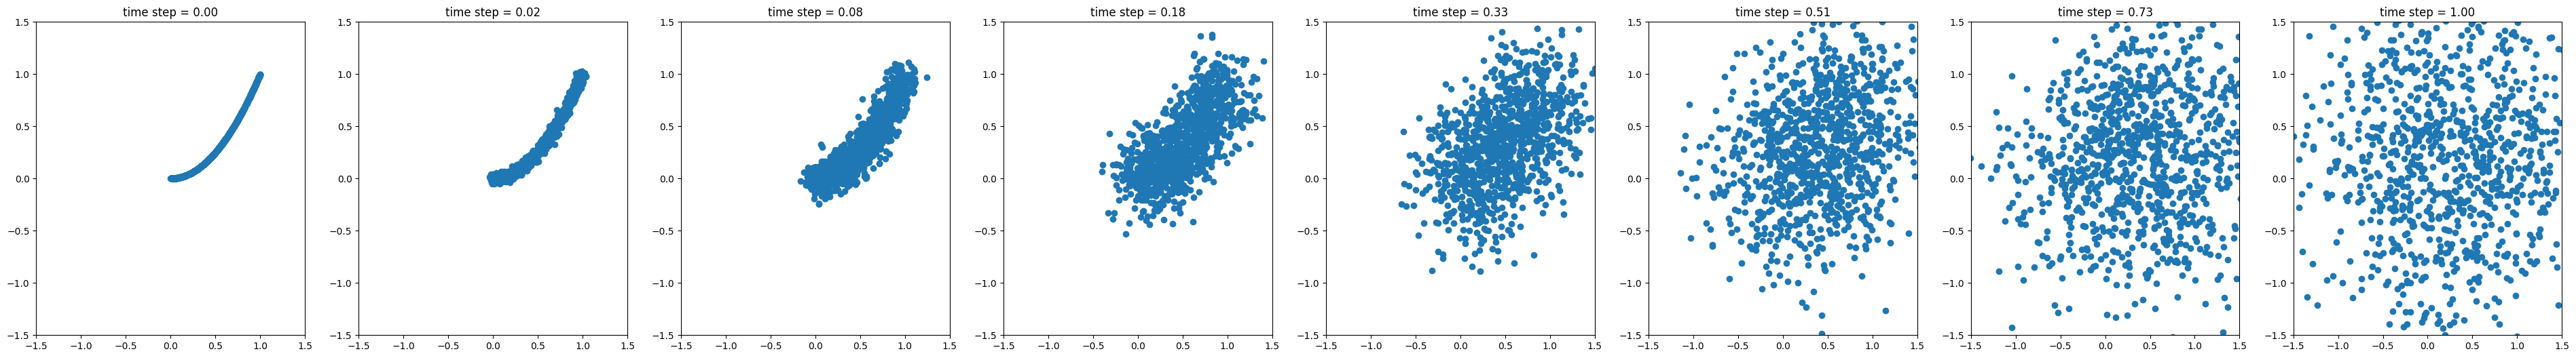

In [82]:
n_grid_points = 8
time_vec = torch.linspace(0,1,n_grid_points)**2
X_0 = torch.stack([torch.stack([dataset.__getitem__(idx)]*n_grid_points) for idx in range(1000)]).transpose(1,0)
X_t, noise, score = sde.run_forward(X_0,time_vec)

fig, axs = plt.subplots(1,n_grid_points, figsize=(6*n_grid_points,6))
for idx in range(n_grid_points):
    axs[idx].scatter(X_t[idx,:,0],X_t[idx,:,1])
    axs[idx].set_xlim(-1.5,1.5)
    axs[idx].set_ylim(-1.5,1.5)
    axs[idx].set_title(f"time step = {time_vec[idx]:.2f}")

In [83]:
TRAIN_SCORE = False #whether to train score or denoiser network

In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FullConnectedScoreModel(nn.Module):
    def __init__(self, data_dim: int = 2, hidden_dim: int = 128, n_hidden_layers: int = 2):
        super(FullConnectedScoreModel, self).__init__()

        # Input layer
        self.input_layer = nn.Linear(data_dim+1, hidden_dim)
        self.input_batch_norm = nn.BatchNorm1d(hidden_dim)

        # Hidden layers
        self.hidden_layers = nn.ModuleList()
        for _ in range(n_hidden_layers):
            layer = nn.Linear(hidden_dim, hidden_dim)
            batch_norm = nn.BatchNorm1d(hidden_dim)
            self.hidden_layers.append(nn.Sequential(layer, batch_norm))

        # Output layer
        self.output_layer = nn.Linear(hidden_dim, data_dim)  # Assuming output is a single value

    def forward(self, x, t):
        x_conc_t = torch.concat([x,t.unsqueeze(1)],axis=1)
        x = F.relu(self.input_batch_norm(self.input_layer(x_conc_t)))

        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))

        return self.output_layer(x)

In [85]:
model = FullConnectedScoreModel()

In [86]:
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 1e-5
N_EPOCHS = 10

optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY,maximize=False)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [87]:
def train_diffusion_model(model, sde: ItoSDE, dataloader: DataLoader, optimizer, device, n_epochs: int, print_every: int, train_score: bool = TRAIN_SCORE):
    model.train()
    model.to(device)

    loss_function = nn.MSELoss()
    running_loss_list = []

    for epoch in range(n_epochs):
        print(f'Epoch: {epoch}')
        running_loss = 0.0
        for idx, x_inp in enumerate(dataloader):
            optimizer.zero_grad()

            X_t, noise, score, time = sde.run_forward_random_times(x_inp)

            X_t = X_t.to(device)
            noise = noise.to(device)
            time = time.to(device)

            model_pred = model(X_t, time)
            
            if train_score:
                loss = loss_function(score, model_pred)
            else:
                loss = loss_function(noise, model_pred)

            loss.backward()
            optimizer.step()

            running_loss += loss.detach().item()
            
            if (idx+1) % print_every == 0:
                avg_loss = running_loss/print_every
                running_loss_list.append(avg_loss)
                running_loss = 0.0
                print(avg_loss)
    return model,running_loss_list             

In [88]:
model,running_loss_list = train_diffusion_model(model, sde, trainloader, optimizer, device=device, n_epochs=N_EPOCHS, print_every=10)

Epoch: 0
1.1040251314640046
0.9568855822086334
0.8860087215900421
0.7861086249351501
0.7259918630123139
0.6174887478351593
0.6170430958271027
Epoch: 1
0.5471163094043732
0.4730751425027847
0.4420048028230667
0.46255050897598265
0.43053717017173765
0.41034814417362214
0.4314793676137924
Epoch: 2
0.36557853519916533
0.360164013504982
0.36252783238887787
0.31213869750499723
0.32037369906902313
0.303960844874382
0.327509343624115
Epoch: 3
0.311093769967556
0.30513081699609756
0.2879278302192688
0.32279409766197203
0.2774901807308197
0.2898868918418884
0.3090476393699646
Epoch: 4
0.278698156774044
0.28862549513578417
0.2802013039588928
0.27172279357910156
0.2842493712902069
0.27444959729909896
0.2817887082695961
Epoch: 5
0.29459477961063385
0.27083734422922134
0.2756500706076622
0.27449858039617536
0.26658223420381544
0.2702829509973526
0.27653160840272906
Epoch: 6
0.2797206252813339
0.25831911712884903
0.29294913411140444
0.2565539002418518
0.28408844470977784
0.29300798773765563
0.2674346

In [89]:
model = model.to('cpu')

In [ ]:
def plot_score_vector_field(model, t: float, sde: ItoSDE, train_score: bool, fpath: str = None, min_x: float = -5.0, max_x: float = 5.0, n_grid_points: int = 50, device: str = 'cpu'):
    """
    Function to plot the score vector field of a diffusion model.
    Arguments:
        model: The trained score or denoiser network.
        t: The time at which to calculate the score.
        sde: The SDE object used for the diffusion process.
        train_score: Whether the model was trained to predict the score directly or the noise.
        fpath: save image to this file path (if given)
        min_x, max_x: float - borders of grid
        n_grid_points: int - number of grid points in each dimension
        device: device to run the model on
    Returns:
        axis object with plot.
    """
    model.eval()
    model.to(device)

    oned_grid = np.linspace(min_x, max_x, n_grid_points)
    twod_grid = np.array([[x, y] for x, y in product(oned_grid, oned_grid)])
    
    grid_tensor = torch.tensor(twod_grid, dtype=torch.float32).to(device)
    t_tensor = (torch.ones(grid_tensor.shape[0]) * t).to(device)

    with torch.no_grad():
        model_pred = model(grid_tensor, t_tensor)

    if train_score:
        score = model_pred.cpu().numpy()
    else:
        # Convert noise prediction to score: score = - eps / std
        cond_std = sde.cond_std(torch.zeros_like(grid_tensor), t_tensor).cpu().numpy()
        # cond_std is a scalar or 1D array of shape (batch,)
        # Ensure it broadcasts correctly with (batch, dim)
        if len(cond_std.shape) == 1:
            cond_std = cond_std[:, np.newaxis]
        
        # Add epsilon to avoid division by zero at t=0
        score = - (model_pred.cpu().numpy() / (cond_std + 1e-8))
    
    fig, my_axis = plt.subplots(figsize=(8, 8))
    my_axis.quiver(twod_grid[:, 0], twod_grid[:, 1], score[:, 0], score[:, 1], scale=50.0)
    my_axis.set_xlim(min_x, max_x)
    my_axis.set_ylim(min_x, max_x)
    my_axis.set_title(f"Score Vector Field at t={t}")

    if fpath is not None:
        plt.savefig(fpath)
    
    plt.show() # Ensure plots are not merged
    return my_axis

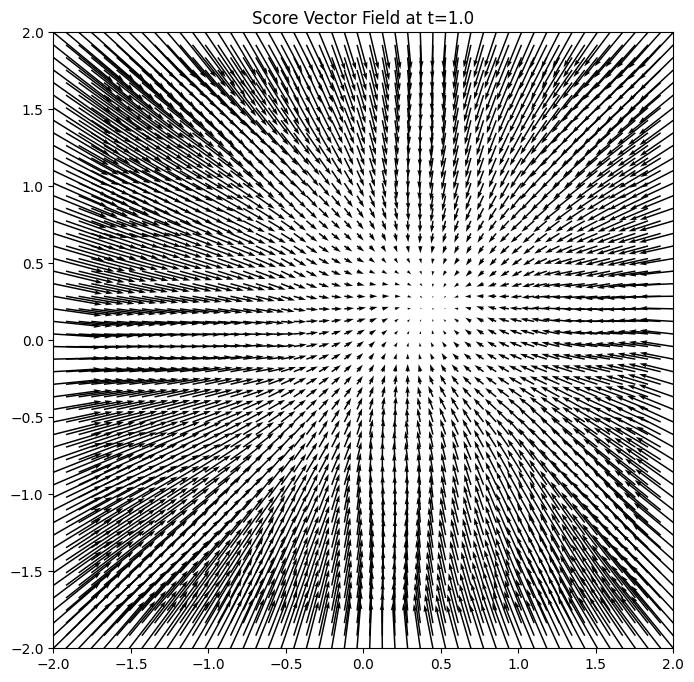

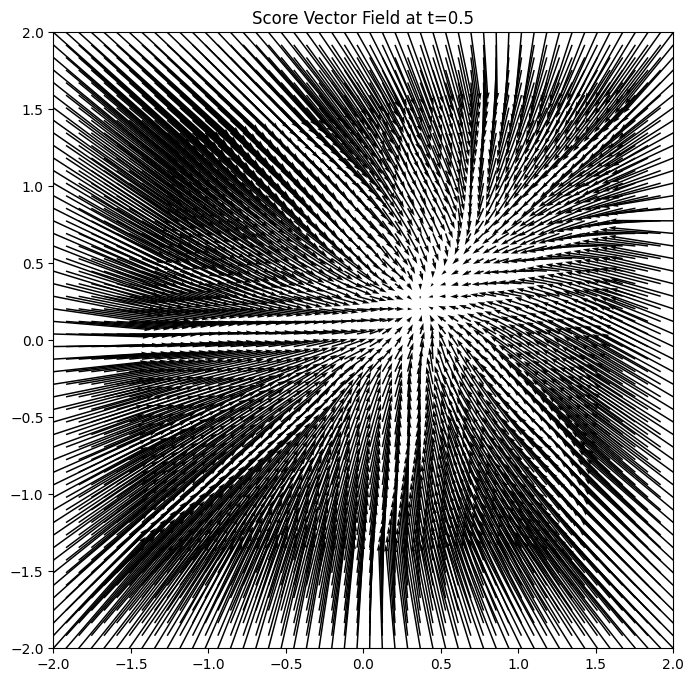

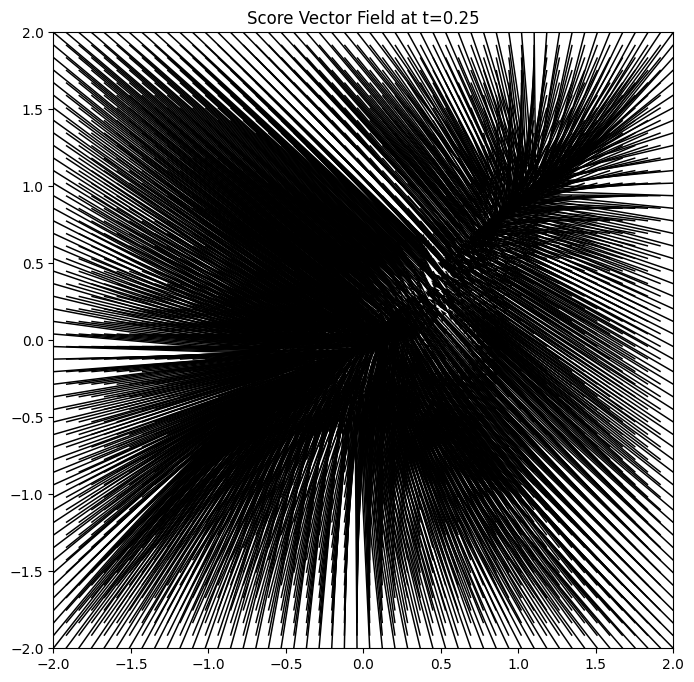

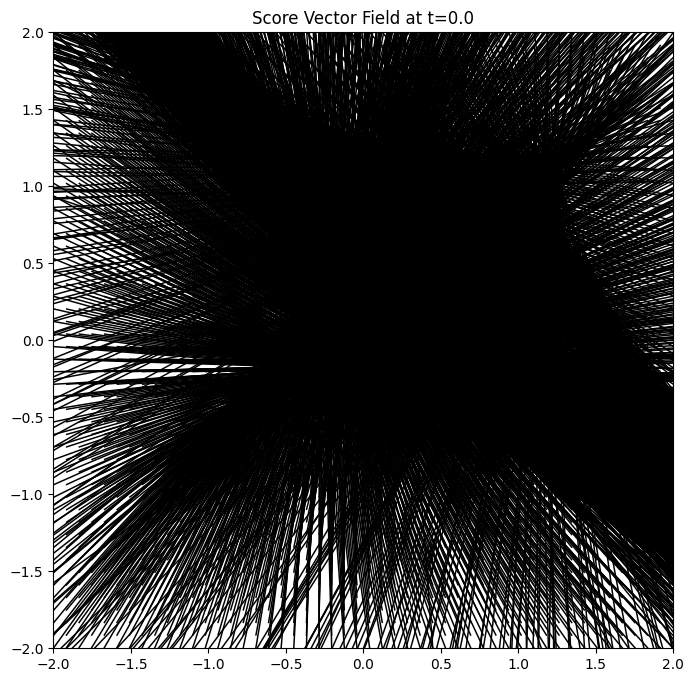

<Axes: title={'center': 'Score Vector Field at t=0.0'}>

In [103]:
plot_score_vector_field(model,t=1.0,min_x=-2.0,max_x=2.0, sde=sde, train_score=TRAIN_SCORE)
plot_score_vector_field(model,t=0.5,min_x=-2.0,max_x=2.0, sde=sde, train_score=TRAIN_SCORE)
plot_score_vector_field(model,t=0.25,min_x=-2.0,max_x=2.0, sde=sde, train_score=TRAIN_SCORE)
plot_score_vector_field(model,t=0.0,min_x=-2.0,max_x=2.0, sde=sde, train_score=TRAIN_SCORE)

In [92]:
def run_backwards(model: torch.nn.Module, sde: ItoSDE, x_start: Tensor, device, train_score, n_steps: int = 10, plot_evolution: bool = True, clip_max: float = 1.0, clip_min: float = -1.0, **kwargs):
    """Function to run stochastic differential equation. We assume a deterministic initial distribution p_0."""
    model = model.to(device)
    
    #Number of trajectories, dimension of data:
    n_traj = x_start.shape[0]
    ndim = x_start.dim()-1

    #Compute time grid for discretization and step size:
    time_grid = torch.linspace(sde.T_max,0,n_steps)
    step_size =torch.abs(time_grid[0]-time_grid[1])

    #Compute the random drift at every time point:
    random_drift_grid = sde.g_random(time_grid)
    
    #Sample random drift at every time point:
    noise = torch.randn(size=(n_steps,*list(x_start.shape)))
    random_drift_grid_sample = torch.sqrt(step_size) * noise * random_drift_grid.view(-1,*[1]*(ndim+1))
    
    #Initialize list of trajectory:
    x_traj = [x_start]

    if plot_evolution:
        fig, axs = plt.subplots(1,len(time_grid),figsize=(6*len(time_grid),6))

    
    for idx,time in tqdm(enumerate(time_grid)):
        
        #Get last location and time
        x = x_traj[idx]
        t = time_grid[idx]
        time_vec = t.repeat(n_traj)
        
        #Deterministic drift: f(X_,t)
        determ_drift = step_size*sde.f_drift(x,time_vec)

        #Get random drift:
        random_drift_sample = random_drift_grid_sample[idx]

        #Get noise estimates:
        model_estimate = model(x.to(device),time_vec.to(device)).detach().cpu()

        if train_score:
            score_estimates = model_estimate
        else:
            denominator = torch.clip(sde.cond_std(None, time_vec),0.01)
            if len(model_estimate.shape) == 4:
                score_estimates = -model_estimate/denominator[:,None,None,None]
            else:
                score_estimates = -model_estimate/denominator[:,None]

        #Correction term: g^2 * score estimate
        g_squared = (random_drift_grid[idx]**2).repeat(n_traj)
        correction_term = (step_size*ItoSDE._mult_first_dim(g_squared,score_estimates))
        
        #Compute next step:
        change = (correction_term - determ_drift) + random_drift_sample
        next_step = x + change
        
        #Save step:
        x_traj.append(next_step)

        if plot_evolution:
            axs[idx].scatter(next_step[:,0],next_step[:,1])
            axs[idx].quiver(next_step[:,0],next_step[:,1],change[:,0],change[:,1])
            axs[idx].set_xlim(-2.0,2.0)
            axs[idx].set_ylim(-2.0,2.0)
            axs[idx].set_title(f"Step={idx}")
            
    output = torch.stack(x_traj) #.transpose(1,0)
    #output = torch.clip(output, clip_min, clip_max)
    return output,time_grid    

0it [00:00, ?it/s]

AttributeError: 'NoneType' object has no attribute 'shape'

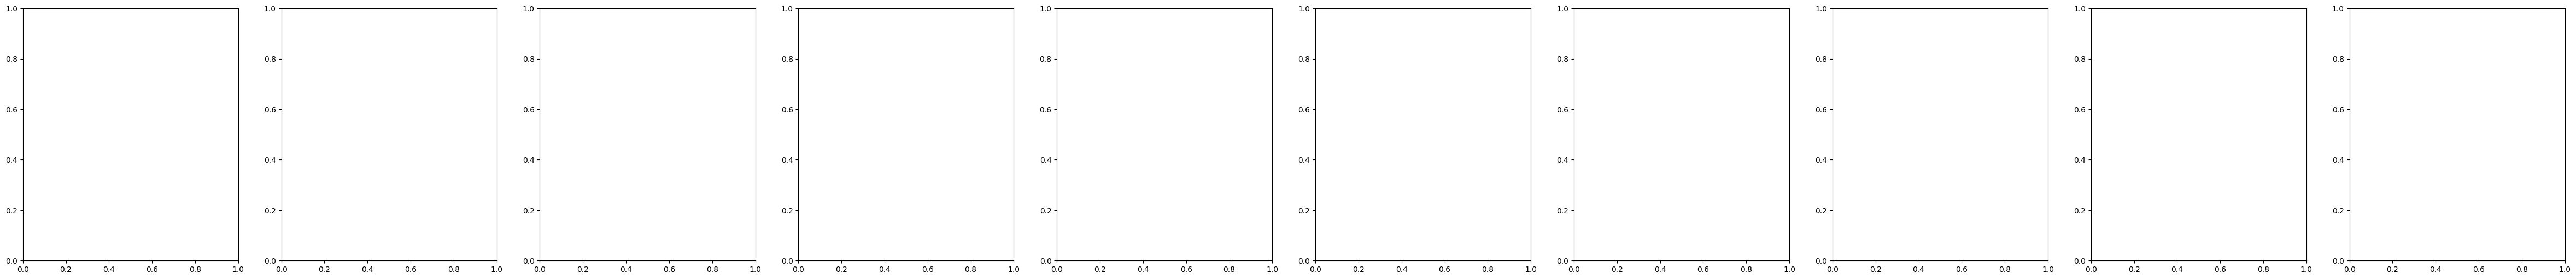

In [93]:
x_start = torch.randn(size=next(enumerate(trainloader))[1].shape)
output,time_grid = run_backwards(model,sde,x_start=x_start,n_steps=10,device=device, train_score=TRAIN_SCORE)

In [ ]:
from IPython.display import HTML
HTML('<img src="diffusion_model_sampling.gif"">')